In [20]:
import numpy as np
import pandas as pd
import glob
import string

import sys,traceback
import ast
from datetime import date
import datetime as dt
import json

from sklearn.model_selection import train_test_split
from nltk.tag import pos_tag
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [21]:
all_data = pd.DataFrame()
for f in glob.glob("./data/*.csv"):
    df = pd.read_csv(f)
    all_data = all_data.append(df,ignore_index=True)

In [22]:
train, test = train_test_split(all_data, test_size = 0.2)

In [23]:
train.created_at.describe()

count                1931
unique               1526
top       11/3/2014 23:48
freq                  146
Name: created_at, dtype: object

In [24]:
def returnDates(x,valid):
    formated_date = ''
    months = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}    
    if x.startswith('"') and x.endswith('"'): x = x[1:-1]
    if x.startswith("'") and x.endswith("'"): x = x[1:-1]
    if x.startswith("'"): x = x[1:]
    date_split = x.split(' ')
    if len(date_split) == 2:
        _date = date_split[0].split('/')
        _date[2] = '20'+_date[2]
        formated_date = ''.join(map(str,_date))
        time = date_split[1]
        # print formated_date , date_split, pd.to_datetime(formated_date, format='%m%d%Y', errors='coerce')
    
    elif len(date_split) == 6:
        m = months[date_split[1]]
        formated_date = '/'.join(map(str,[m,date_split[2],date_split[5]]))
        if formated_date[-1] == '"': formated_date = formated_date[:-1]
        #print formated_date, date_split, pd.to_datetime(formated_date, format='%m/%d/%Y', errors='coerce')    
    
    if valid:
        return pd.to_datetime(formated_date, format='%m/%d/%Y', errors='coerce')
    else:
        return pd.to_datetime(time,format='%H:%M').hour

In [33]:
def lexical_diversity(text):
  if len(text) == 0:
    diversity = 0
  else: 
    diversity = float(len(set(text))) / len(text)
  return diversity
    
def get_Noun(x):
    word = str(x).strip()
    count = 0
    tagged_sent = pos_tag(word.split())
    for w in tagged_sent:
        if w[1] == 'NNP':
            count+=1
    return count

def return_dict(x):
    if not pd.isnull(x) and x.find('_json=') != -1:
        x = x[x.find('_json=')+6:x.find(', coordinates=')]
        x = ast.literal_eval(x)
        return x
    else:
        return None

def status_created_date(x):
    print x
    if not pd.isnull(x):
        x = return_dict(x)
        return returnDates(x['created_at'],True)
    else:
        return None

In [34]:
def status(df):
    df['status_dict'] = df.status.apply(return_dict)
    return df

def tweetsperDay(df):
    df.loc[:,'statuses_count']= df.statuses_count.apply(lambda x: int(x)+1)
    df.loc[:,'tweets_per_day'] = df.statuses_count/df.acc_age
    return df

def status_created_at(df):
    df['status_created_at'] = df.status.apply(status_created_date)

def account_age(df):
    df['status_created_at'] = df.status.apply(created_date_status)
    return df

def ff_ratio(df):
    df.followers_count = df.followers_count.apply(lambda x: int(x)+1)
    df.friends_count = df.friends_count.apply(lambda x: int(x)+1)
    df.loc[:,'ff_ratio'] = (df.followers_count/df.friends_count)
    return df
    
def simplfy_followerscount(df):
    bins = (0, 46,358,14917,96321560,sys.maxint)
    group_names = ['1_quartile', '2_quartile', '3_quartile', '4_quartile', '5_quartile']
    categories = pd.cut(df.followers_count, bins, labels=group_names)
    df.followers_count = categories
    return df  

def simplfy_friendscount(df):
    bins = (0, 10,197,671,978964,sys.maxint)
    group_names = ['1_quartile', '2_quartile', '3_quartile', '4_quartile', '5_quartile']
    categories = pd.cut(df['friends_count'], bins, labels=group_names)
    df.friends_count = categories
    return df    

def simplfy_listedcount(df):
    df.loc[:,'listedcount']= df.listedcount.apply(lambda x: int(x)+1)
    bins = (0, 2,18,360,222411,sys.maxint)
    group_names = ['1_quartile', '2_quartile', '3_quartile', '4_quartile', '5_quartile']
    categories = pd.cut(df['listedcount'], bins, labels=group_names)
    df.loc[:,'listedcount'] = categories
    return df    

def simplfy_favouritescount(df):
    df.loc[:,'favourites_count']= df.favourites_count.apply(lambda x: int(x)+1)
    bins = (0,2,25,484,714021,sys.maxint)
    group_names = ['1_quartile', '2_quartile', '3_quartile', '4_quartile', '5_quartile']
    categories = pd.cut(df.favourites_count, bins, labels=group_names)
    df.loc[:,'favourites_count']= categories
    return df  

def simplfy_statusescount(df):
    df.loc[:,'statuses_count']= df.statuses_count.apply(lambda x: int(x)+1)
    bins = (0,178,2290,10025,6863363,sys.maxint)
    group_names = ['1_quartile', '2_quartile', '3_quartile', '4_quartile', '5_quartile']
    categories = pd.cut(df.statuses_count, bins, labels=group_names)
    df.loc[:,'statuses_count']= categories
    return df 

def drop_features(df):
    return df.drop(['id', 'id_str', 'location','lang','status','created_at'], axis=1)

def replace_None(df):
    df.loc[:,'has_extended_profile'] = df['has_extended_profile'].fillna(df.has_extended_profile.median())
    return df

def format_date(df):
    df.loc[:,'modified_date'] = df.created_at.apply(lambda x: returnDates(x,True))
    df.loc[:,'modified_hour'] = df.created_at.apply(lambda x: returnDates(x,False))
    return df

def diversity(df):
    df.loc[:,'description'].fillna("")    
    df.loc[:,'sn_length'] = df.screen_name.apply(lambda text: len(str(text)))
    df.loc[:,'desc_length'] = df.description.apply(lambda text: len(str(text)))
    grouped = df['screen_name']
    df['diversity'] = grouped.apply(lexical_diversity)
    df.loc[:,'null_url'] = df.url.apply(lambda x: 1 if (str(x).find('http'))!=-1 else 0)
    return df


def transform_features(df):
    #df = ff_ratio(df)
    #df = format_date(df)    
    #df = account_age(df) 
    #df = status(df)
    df = status_created_at(df)
    '''
    df = tweetsperDay(df)
    df = simplfy_followerscount(df)
    df = simplfy_friendscount(df)
    df = simplfy_listedcount(df)
    df = simplfy_favouritescount(df)
    df = simplfy_statusescount(df)   
    df = replace_None(df)  
    df = diversity(df)
    df = drop_features(df)
    '''
    return df

train = transform_features(train)
test = transform_features(test)
train.head()

AttributeError: 'NoneType' object has no attribute 'status'

In [ ]:
train.head()

In [56]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['followers_count','friends_count','listedcount','favourites_count','verified','statuses_count', \
                'default_profile','default_profile_image','has_extended_profile','ff_ratio','sn_length','desc_length'\
                ,'diversity','null_url','acc_age_bins','tweets_per_day']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train.loc[:,feature] = le.transform(df_train[feature])
        df_test.loc[:,feature] = le.transform(df_test[feature])
    return df_train, df_test
    
train, test = encode_features(train, test)
train.head()

,screen_name,description,url,followers_count,friends_count,listedcount,favourites_count,verified,statuses_count,default_profile,...,ff_ratio,modified_date,status_created_at,acc_age,acc_age_bins,tweets_per_day,sn_length,desc_length,diversity,null_url
1276,PSOE,Twitter oficial del PSOE.,https://t.co/UJQJuoxTW2,3,3,3,3,1,3,0,...,1223,2009-06-26,2017-03-12,2817,3,1925,2,23,51,1
1071,LillianSaysSo,"Director, Predictive Analytics & Business Inte...",https://t.co/K15zb8dSNS,2,3,2,2,0,2,1,...,518,2009-03-05,2017-03-13,2931,3,955,11,156,23,1
985,jajlang,"Defining a new API is easy, all you need is a ...",https://t.co/xoih6a0ldc,0,0,1,0,0,2,1,...,1105,2015-07-02,2016-01-11,194,0,1716,5,135,26,1
734,xzavierm18,Passionate about helping people elevate themse...,NaN,0,2,0,2,0,1,1,...,69,2016-09-09,2017-03-13,186,0,843,8,152,51,0
848,oneiropoiesis,"Every few hours, a new Twitter dream. By @apar...",http://t.co/DvFcRNkIN2,1,0,2,0,0,2,1,...,1435,2014-01-04,2017-03-12,1164,1,1587,11,126,10,1


In [57]:
X_all = train.drop(['bot','modified_date','screen_name','description','url','name','status_created_at','acc_age'], axis=1)
y_all = train['bot']

In [58]:
X_all.head()

,followers_count,friends_count,listedcount,favourites_count,verified,statuses_count,default_profile,default_profile_image,has_extended_profile,ff_ratio,acc_age_bins,tweets_per_day,sn_length,desc_length,diversity,null_url
1276,3,3,3,3,1,3,0,0,1,1223,3,1925,2,23,51,1
1071,2,3,2,2,0,2,1,0,1,518,3,955,11,156,23,1
985,0,0,1,0,0,2,1,0,0,1105,0,1716,5,135,26,1
734,0,2,0,2,0,1,1,0,0,69,0,843,8,152,51,0
848,1,0,2,0,0,2,1,0,0,1435,1,1587,11,126,10,1


In [61]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# load the iris datasets
# create a base classifier used to evaluate a subset of attributes
model = LogisticRegression()
model2 = ExtraTreesClassifier()
# create the RFE model and select 3 attributes
rfe = RFE(model, 5)
rfe = rfe.fit(X_all, y_all)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)
model2.fit(X_all, y_all)
# display the relative importance of each attribute
print(model2.feature_importances_)

[False False False  True  True  True False False  True False  True False
 False False False False]
[ 4  8  3  1  1  1  2  5  1 12  1 11  7  9 10  6]
[ 0.06771394  0.07800999  0.02396871  0.10182705  0.12606927  0.03301373
  0.04545013  0.01351365  0.02451754  0.09581048  0.18838866  0.08285697
  0.0354165   0.03671266  0.03106427  0.01566645]


In [60]:
list(X_all)

['followers_count',
 'friends_count',
 'listedcount',
 'favourites_count',
 'verified',
 'statuses_count',
 'default_profile',
 'default_profile_image',
 'has_extended_profile',
 'ff_ratio',
 'acc_age_bins',
 'tweets_per_day',
 'sn_length',
 'desc_length',
 'diversity',
 'null_url']

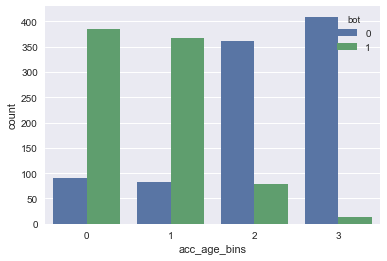

In [63]:
sns.countplot(x="acc_age_bins", hue="bot", data=train);

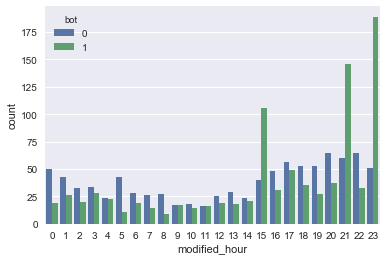

In [128]:
sns.countplot(x="modified_hour", hue="bot", data=train);